In [1]:
from glob import glob
from collections import defaultdict
from os.path import basename
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import roc_curve, auc
from pqdm.processes import pqdm
from scipy.stats import ttest_rel

os.chdir('/home/vladimirnoz/ibis')

HITS_THR = 10

In [2]:
g2a = set(pd.read_table('finals.tsv').query('`Primary Discipline` == "G2A"')['Transcription factor'])

In [3]:
g2a

{'CAMTA1',
 'LEUTX',
 'MYF6',
 'PRDM13',
 'SALL3',
 'USF3',
 'ZBED2',
 'ZBED5',
 'ZNF20',
 'ZNF251',
 'ZNF367',
 'ZNF395',
 'ZNF493',
 'ZNF518B',
 'ZNF648'}

In [4]:
paths = glob('aaa_submissions/*/*@*')
pwms = defaultdict(list)
tables_list = []
for file in tqdm(paths):
    title = basename(file).replace('GHTS', 'ghtselex').replace('CHS', 'chipseq').replace('.txt', '')
    team_name = file.split('/')[-2]
    scores = pd.read_table(file, names=['score'])
    snps = pd.read_table(f'fasta/{title}.fasta', names=['name'])['name']
    snps = snps[snps.str.match('>')].str.replace('>', '').str.split('@', expand=True).reset_index().drop('index', axis=1)
    snps.columns = ['#chr', 'end', 'ref', 'alt', 'allele']
    snps['score'] = scores
    asb = pd.read_table(f'asb/{title.replace("ght", "")}.tsv')
    asb['ref_score'] = snps.query('allele == "ref"').reset_index()['score']
    asb['alt_score'] = snps.query('allele == "alt"').reset_index()['score']
    tf = title.split('@')[1]
    asb['tf'] = tf
    asb['exp'] = title.split('@')[0]
    asb['team'] = team_name
    asb['discipline'] = 'G2A' if tf in g2a else 'A2G'
    tables_list.append(asb)
df = pd.concat(tables_list)
df['score'] = df[['ref_score', 'alt_score']].max(axis=1)
df

  0%|          | 0/210 [00:00<?, ?it/s]

,#chr,start,end,mean_bad,id,max_cover,ref,alt,n_reps,bads,...,comb_es,comb_pval,fdr_comb_pval,ref_score,alt_score,tf,exp,team,discipline,score
0,chr2,60552342,60552343,1.0,rs7576657,22,A,C,2,"1,1",...,0.713616,6.170967e-02,0.313383,0.406316,0.395225,GCM1,chipseq,Salimov.and.Frolov.Laboratory,A2G,0.406316
1,chr7,157010642,157010643,2.0,rs885832,203,G,C,2,"2,2",...,1.654394,1.662976e-03,0.042398,0.398292,0.400383,GCM1,chipseq,Salimov.and.Frolov.Laboratory,A2G,0.400383
2,chr16,1984135,1984136,2.0,rs56119017,84,C,T,2,"2,2",...,2.516640,3.996541e-07,0.000075,0.226159,0.218792,GCM1,chipseq,Salimov.and.Frolov.Laboratory,A2G,0.226159
3,chr1,28736723,28736724,2.0,rs3738067,41,G,A,2,"2,2",...,1.330021,1.983249e-02,0.179259,0.338450,0.339896,GCM1,chipseq,Salimov.and.Frolov.Laboratory,A2G,0.339896
4,chr1,32205632,32205633,2.0,rs16834929,57,C,T,2,"2,2",...,0.919113,9.212019e-02,0.377721,0.303725,0.296856,GCM1,chipseq,Salimov.and.Frolov.Laboratory,A2G,0.303725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,chr5,81972014,81972015,3.0,rs112181309,56,G,T,1,3,...,1.278773,4.490210e-02,0.239866,0.684992,0.707944,MYPOP,ghtselex,Biology.Impostor,A2G,0.707944
59,chr5,107939012,107939013,3.0,rs79955751,38,C,T,1,3,...,1.171158,5.594850e-02,0.472454,0.579804,0.555051,MYPOP,ghtselex,Biology.Impostor,A2G,0.579804
60,chr12,108562580,108562581,2.0,rs2287554,84,C,T,2,"2,2",...,-0.004261,3.022081e-01,0.791994,0.518816,0.519493,MYPOP,ghtselex,Biology.Impostor,A2G,0.519493
61,chr15,78800407,78800408,2.0,rs7173267,27,G,C,1,2,...,-0.198680,3.734469e-01,0.937103,0.552379,0.578232,MYPOP,ghtselex,Biology.Impostor,A2G,0.578232


In [5]:
np.random.seed(777)

random = df[['#chr', 'start', 'end', 'ref', 'alt', 'comb_pval', 'ref_comb_pval', 'alt_comb_pval', 'discipline', 'tf', 'fdr_comb_pval']].drop_duplicates()
random = random.query('fdr_comb_pval < 0.05')
random['ref_score'] = np.random.rand(len(random))
random['alt_score'] = np.random.rand(len(random))
random

,#chr,start,end,ref,alt,comb_pval,ref_comb_pval,alt_comb_pval,discipline,tf,fdr_comb_pval,ref_score,alt_score
1,chr7,157010642,157010643,G,C,1.662976e-03,1.662976e-03,8.534672e-01,A2G,GCM1,4.239847e-02,0.152664,0.898289
2,chr16,1984135,1984136,C,T,3.996541e-07,3.996541e-07,9.999931e-01,A2G,GCM1,7.488185e-05,0.302357,0.276551
19,chr12,6944198,6944199,A,G,7.181746e-04,7.181746e-04,9.309664e-01,A2G,GCM1,2.454018e-02,0.062036,0.459858
22,chr13,41961120,41961121,A,T,2.630554e-04,9.773495e-01,2.630554e-04,A2G,GCM1,1.263790e-02,0.459860,0.900924
25,chr13,114234989,114234990,T,C,8.215895e-04,8.215895e-04,9.935313e-01,A2G,GCM1,2.700675e-02,0.835253,0.115327
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,chr9,98537276,98537277,A,C,2.568283e-19,1.000000e+00,2.568283e-19,G2A,ZNF251,2.080309e-17,0.247561,0.528480
41,chr9,113715316,113715317,C,T,4.800664e-04,2.540824e-01,4.800664e-04,G2A,ZNF251,1.296179e-02,0.245845,0.091500
49,chr16,11539575,11539576,T,C,1.581985e-05,1.581985e-05,9.999174e-01,G2A,ZNF251,6.407040e-04,0.365600,0.119950
66,chr12,100678438,100678439,C,T,6.835797e-04,1.000000e+00,6.835797e-04,G2A,ZNF251,1.384249e-02,0.250145,0.544458


In [6]:
df['team'].unique()

array(['Salimov.and.Frolov.Laboratory', 'mj', 'pwmsandme', 'Medici',
       'Biology.Impostor'], dtype=object)

In [7]:
def get_concordance(row, thr):
     model_ref, model_alt = row['ref_score'], row['alt_score']
     as_ref, as_alt = row['ref_comb_pval'], row['alt_comb_pval']
     hit = max(model_ref, model_alt) > thr
     if not hit:
         return 'No Hit'
     elif (as_alt - as_ref) * (model_ref - model_alt) > 0:
         return 'Concordant'
     else:
          return 'Discordant'

def get_curve(df):
    thresholds = np.linspace(df[['ref_score', 'alt_score']].min().min(), df[['ref_score', 'alt_score']].max().max(), num=100)
    thresholds = sorted(df[['ref_score', 'alt_score']].max(axis=1))
    rows = []
    for thr in thresholds:
        mini_df = df.copy()
        mini_df['motif_conc'] = mini_df.apply(lambda x: get_concordance(x, thr), axis=1)
        hits = mini_df.query('motif_conc != "No Hit"').copy()
        if len(hits) == 0:
            continue
        conc = hits.query('motif_conc == "Concordant"')
        rows.append([len(hits), len(conc)/len(hits), thr])
    return pd.DataFrame(rows, columns=['hits', 'conc_ratio', 'thr'])

def get_auc(df):
    x = get_curve(df)
    x['hits'] = x['hits']/x['hits'].max()
    area = auc(x['hits'], x['conc_ratio'])
    return area

def process_team(triple):
    team, tf, df, n = triple
    auc_score = get_auc(df)
    disc = 'Discipline.G2A' if tf in g2a else 'Discipline.A2G'
    return [team, tf, auc_score, disc, n]

In [8]:
mini_df = df.query('fdr_comb_pval < 0.05')
mini_df_pairs = mini_df[['team', 'tf']].drop_duplicates()
triples = []

for _, (team, tf) in mini_df_pairs.iterrows():
    mini_df_from_pair = mini_df[(mini_df['team'] == team) * (mini_df['tf'] == tf)].copy()
    if len(mini_df_from_pair) < HITS_THR:
        continue
    triples.append((team, tf, mini_df_from_pair, len(mini_df_from_pair)))
aaa_df = pd.DataFrame(pqdm(triples, process_team, n_jobs=100), columns=['team', 'tf', 'auc', 'discipline', 'n'])
aaa_df['model_type'] = 'AAA'

QUEUEING TASKS | :   0%|          | 0/87 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/87 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/87 [00:00<?, ?it/s]

In [9]:
factors_teams = {
    'MYF6': ['Medici', 'mj'],
    'GCM1': ['Salimov.and.Frolov.Laboratory', 'Biology.Impostor']
}

for tf, team_list in factors_teams.items():
    for team in team_list:
        mini_df_from_pair = mini_df[(mini_df['team'] == team) * (mini_df['tf'] == tf)].copy()
        curve_df = get_curve(mini_df_from_pair)
        g2a_flag = 'G2A' if tf in g2a else 'A2G'
        path_to_save = f'curves_plots/curves/{tf}@{team}@AAA@{g2a_flag}@AAA.tsv'
        curve_df.to_csv(path_to_save, index=False, sep='\t')

In [10]:
mini_df[mini_df['team'] == 'Salimov.and.Frolov.Laboratory']['tf'].unique()

array(['GCM1', 'ZFTA', 'ZNF831', 'SP140L', 'MYPOP', 'TPRX1', 'FIZ1',
       'ZNF500', 'ZNF721', 'MKX', 'CREB3L3', 'ZNF780B', 'ZBTB47',
       'MSANTD1'], dtype=object)

In [11]:
triples = []
random = df.query('fdr_comb_pval < 0.05')
random = random[['#chr', 'start', 'end', 'ref', 'alt', 'comb_pval', 'ref_comb_pval', 'alt_comb_pval', 'discipline', 'tf', 'fdr_comb_pval']].drop_duplicates()
for tf in random['tf'].unique():
    mini_df = random[random['tf'] == tf].copy()
    if len(mini_df) < HITS_THR:
        continue
    for _ in range(10):
        mini_df['ref_score'] = np.random.rand(len(mini_df))
        mini_df['alt_score'] = np.random.rand(len(mini_df))
        triples.append(('random', tf, mini_df.copy(), len(mini_df)))
random_df = pd.DataFrame(pqdm(triples, process_team, n_jobs=100), columns=['team', 'tf', 'auc', 'discipline', 'n'])
random_df = random_df.groupby(['team', 'tf', 'discipline', 'n'])[['auc']].mean().reset_index()
random_df['model_type'] = 'random'

QUEUEING TASKS | :   0%|          | 0/250 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/250 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/250 [00:00<?, ?it/s]

In [12]:
pwm_df = pd.read_table('tables/pwm_auc.tsv')
pwm_df = pwm_df.groupby(['team', 'tf', 'discipline']).agg(
    auc=pd.NamedAgg(column="auc", aggfunc="mean"),
    n=pd.NamedAgg(column="n", aggfunc="min"),
).reset_index()
pwm_df['model_type'] = 'PWM'
results_disc = pd.concat([pwm_df, aaa_df, random_df])
results_disc['team'] = results_disc['team'].str.replace('mex', 'MEX')

tables = []
for _, (team, discipline, model_type) in results_disc[['team', 'discipline', 'model_type']].drop_duplicates().iterrows():
    mini_df = results_disc.query(f'team == "{team}" & discipline == "{discipline}" & model_type == "{model_type}"').copy()
    auc = mini_df['auc']
    n = mini_df['n']
    weighted_avg = np.average(auc, weights=n)
    tables.append([team, discipline, model_type, weighted_avg, n.sum()])
weighted_auc = pd.DataFrame(tables, columns=['team', 'discipline', 'model_type', 'auc', 'n'])
weighted_auc['tf'] = 'Weighted Mean'
results_disc = pd.concat([weighted_auc, results_disc]).sort_values(['team', 'discipline', 'tf'])

results_disc.query('~((team == "Medici" & discipline == "Discipline.A2G"))').to_csv('ibis_auc_scores.tsv', index=False, sep='\t')

In [14]:

tables = []
for _, (team, discipline, model_type) in results_disc[['team', 'discipline', 'model_type']].drop_duplicates().iterrows():
    mini_df = results_disc.query(f'team == "{team}" & discipline == "{discipline}" & model_type == "{model_type}"').copy()
    for tf in mini_df['tf'].unique():
        one_out = mini_df.query(f'tf != "{tf}"')
        auc = one_out['auc']
        n = one_out['n']
        weighted_avg = np.average(auc, weights=n)
        tables.append([team, discipline, model_type, weighted_avg, tf])
weighted_auc = pd.DataFrame(tables, columns=['team', 'discipline', 'model_type', 'auc', 'tf'])

In [15]:
results_disc[['tf', 'discipline']].drop_duplicates().groupby(['discipline']).count()

,tf
discipline,
Discipline.A2G,13
Discipline.G2A,14


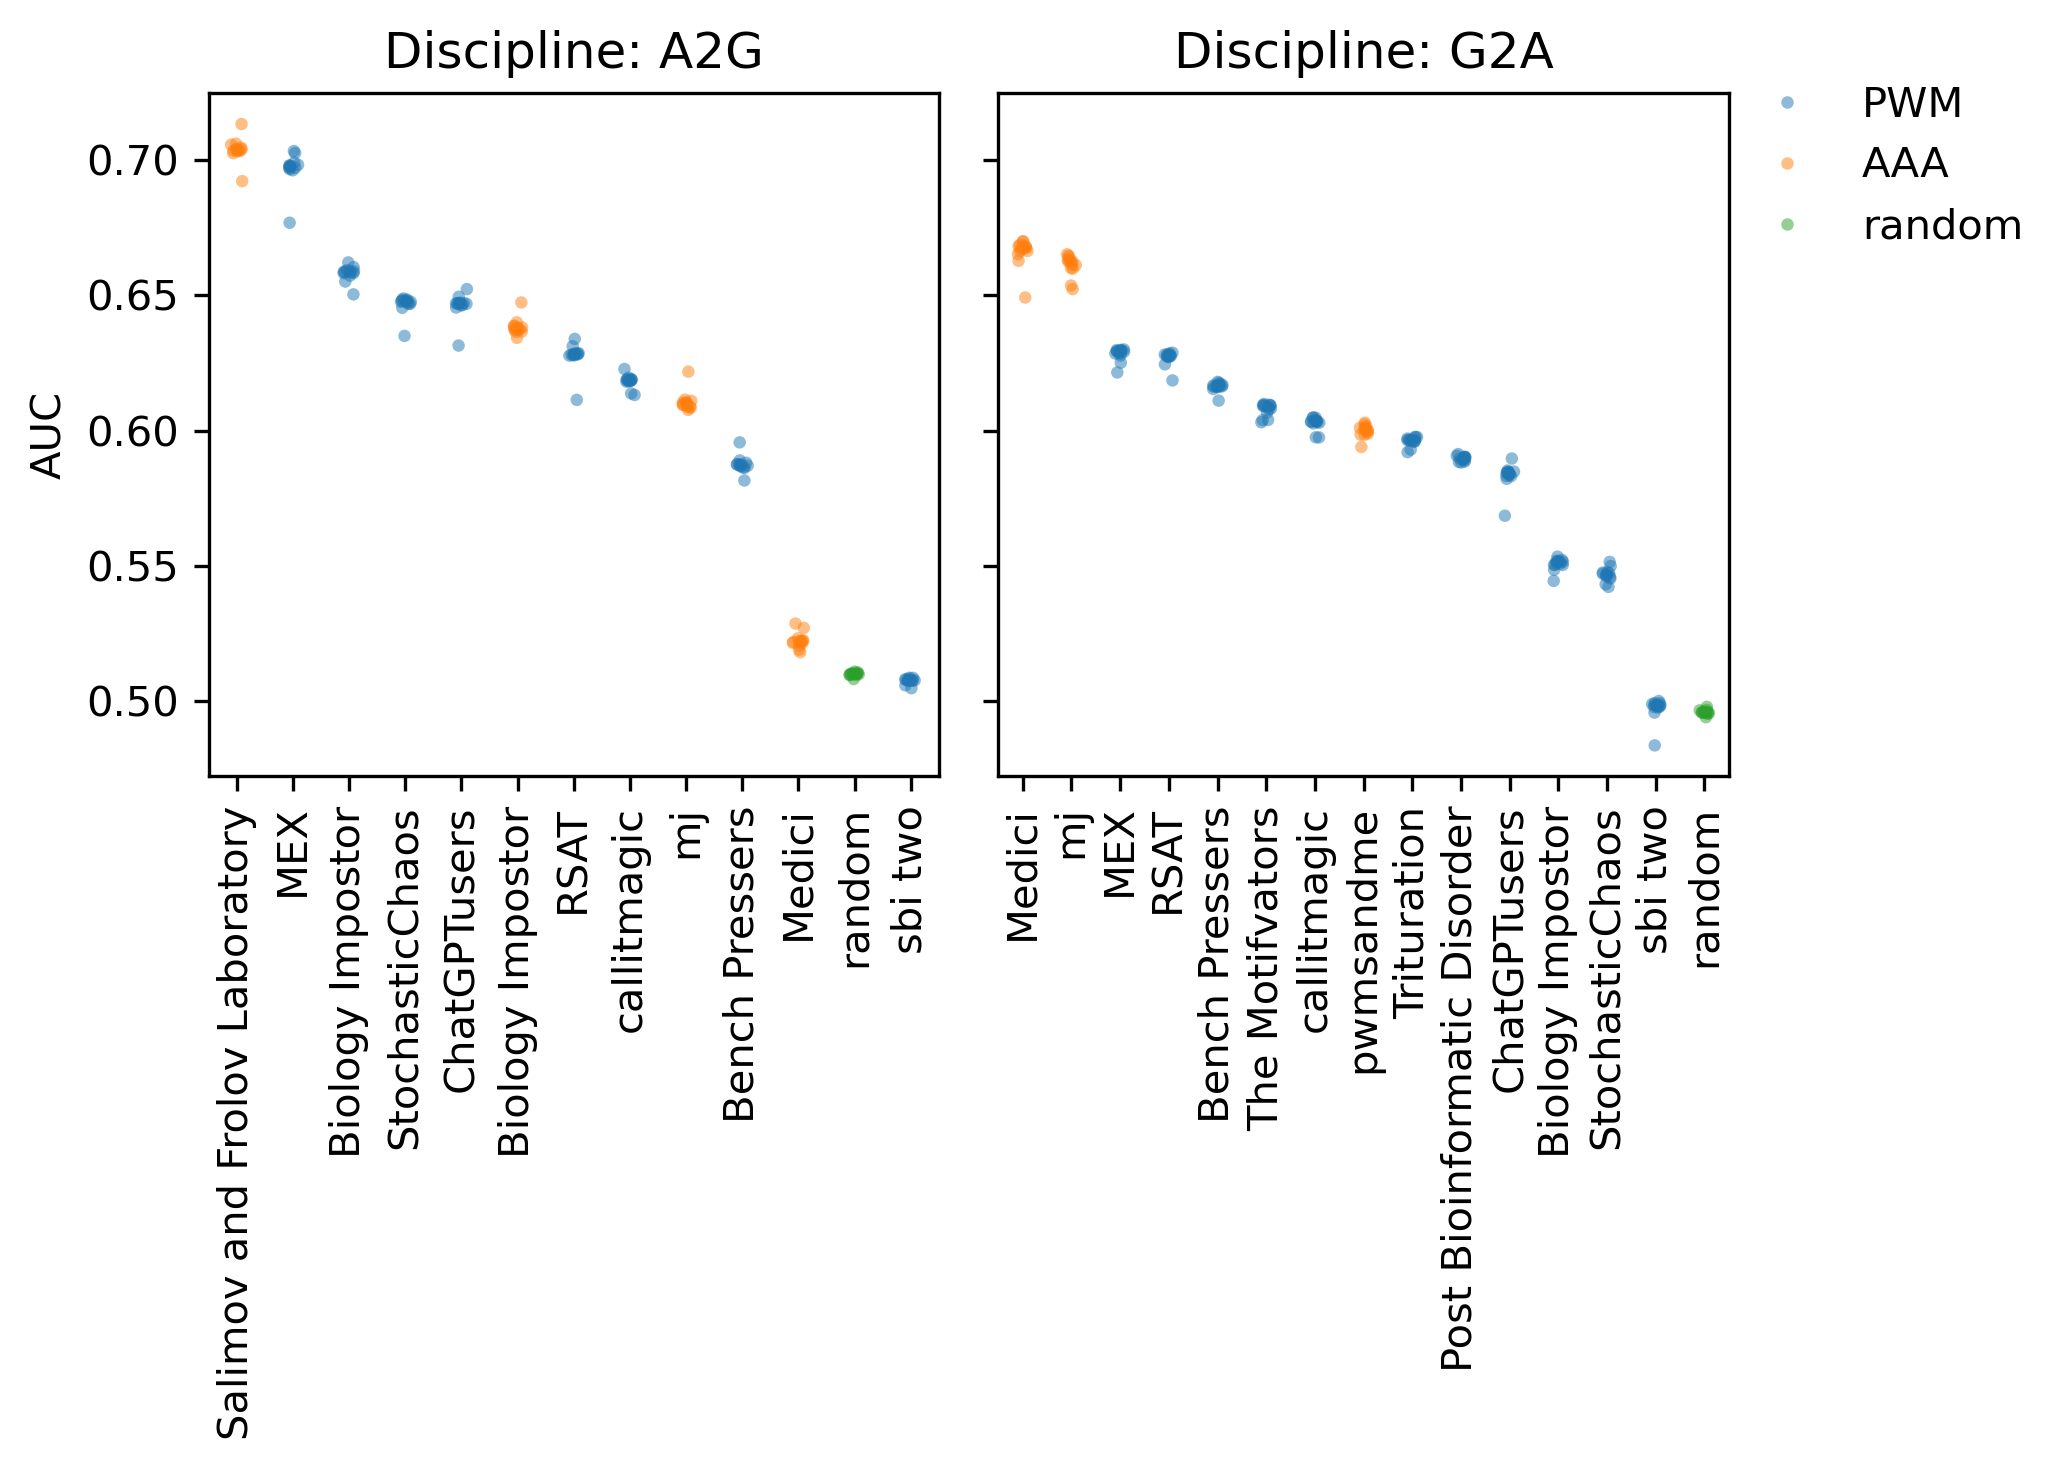

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(7, 5), dpi=300, sharey=True)

maxs = weighted_auc.groupby(['team', 'discipline', 'model_type', 'tf'])[['auc']].max().reset_index()
medians = maxs.groupby(['team', 'discipline', 'model_type'])['auc'].median().reset_index()

for i, (ax, dis) in enumerate(zip(axs, maxs['discipline'].unique())):
    query = f'discipline == "{dis}"'
    mini_df = maxs.query(query)
    order = medians.query(query).sort_values('auc', ascending=False)['team']
    sns.stripplot(data=mini_df, x='team', y='auc', ax=ax, order=order, hue='model_type', size=3, alpha=0.5)
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(order.str.replace('.', ' '), rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel('AUC')
    ax.set_title(dis.replace('.', ': '))
    if i == 1:
        ax.legend(frameon=False, loc=[1, 0.75])
    else:
        ax.get_legend().remove()
fig.tight_layout()
plt.savefig('figures/aaa_auc_weighed_mean_strip.png', bbox_inches='tight')